# Finetune ResNet50


With 1000 x 400 melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:

FINETUNED_MODEL = 'resnet50'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.30it/s, Loss=1.7743364572525024, Elapsed=21.4284s, ETA=0.0000s]  


Epoch 1 completed in 74.4612s
Train Loss: 1.4295713570765678 - Train Accuracy: 43.895434295922755
Validation Loss: 1.2939688618977865 - Validation Accuracy: 49.736175601519626

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.98it/s, Loss=1.7582439184188843, Elapsed=20.2464s, ETA=0.0000s] 


Epoch 2 completed in 73.7773s
Train Loss: 1.2764598703108772 - Train Accuracy: 49.98303973225391
Validation Loss: 1.3030535984039306 - Validation Accuracy: 50.62262558041367

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.89it/s, Loss=1.4464527368545532, Elapsed=20.4575s, ETA=0.0000s] 


Epoch 3 completed in 72.6108s
Train Loss: 1.2339602443524178 - Train Accuracy: 51.94364668370232
Validation Loss: 1.2603404553731283 - Validation Accuracy: 51.73068805403124

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.88it/s, Loss=1.5104973316192627, Elapsed=20.4775s, ETA=0.0000s] 


Epoch 4 completed in 72.5724s
Train Loss: 1.2063887465551408 - Train Accuracy: 53.10372899753511
Validation Loss: 1.214285403887431 - Validation Accuracy: 53.14478682988602

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.83it/s, Loss=1.6319130659103394, Elapsed=20.4138s, ETA=0.0000s] 


Epoch 5 completed in 73.1363s
Train Loss: 1.1879240258925223 - Train Accuracy: 53.92008321838041
Validation Loss: 1.2001253986358642 - Validation Accuracy: 54.010130856901654

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.90it/s, Loss=1.6100081205368042, Elapsed=20.2697s, ETA=0.0000s] 


Epoch 6 completed in 72.1773s
Train Loss: 1.1795820390557967 - Train Accuracy: 54.13717464553041
Validation Loss: 1.1909439357121785 - Validation Accuracy: 54.242296327564375

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.97it/s, Loss=1.3711822032928467, Elapsed=20.2399s, ETA=0.0000s] 


Epoch 7 completed in 72.1827s
Train Loss: 1.164996696173111 - Train Accuracy: 54.57361886886321
Validation Loss: 1.2173862759272258 - Validation Accuracy: 53.51414098775855

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.89it/s, Loss=1.339354395866394, Elapsed=20.6956s, ETA=0.0000s]  


Epoch 8 completed in 72.9736s
Train Loss: 1.154414582286956 - Train Accuracy: 55.082426901246016
Validation Loss: 1.1851094055175782 - Validation Accuracy: 54.02068383284087

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.85it/s, Loss=1.4434328079223633, Elapsed=20.5058s, ETA=0.0000s] 


Epoch 9 completed in 73.5321s
Train Loss: 1.1443076831412453 - Train Accuracy: 55.90556522918975
Validation Loss: 1.1750003910064697 - Validation Accuracy: 54.37948501477416

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.01it/s, Loss=1.4308668375015259, Elapsed=20.1358s, ETA=0.0000s] 


Epoch 10 completed in 72.2953s
Train Loss: 1.137986445185766 - Train Accuracy: 56.023156418896
Validation Loss: 1.1759961064656574 - Validation Accuracy: 55.07598142676235

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.91it/s, Loss=1.1413731575012207, Elapsed=20.4654s, ETA=0.0000s] 


Epoch 11 completed in 72.3166s
Train Loss: 1.134248165553705 - Train Accuracy: 56.01184957373194
Validation Loss: 1.2022320556640624 - Validation Accuracy: 53.66188265090756

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.78it/s, Loss=1.6603795289993286, Elapsed=20.3901s, ETA=0.0000s] 


Epoch 12 completed in 73.1947s
Train Loss: 1.1228117065967163 - Train Accuracy: 56.57945320096787
Validation Loss: 1.1618581787745157 - Validation Accuracy: 55.719712959054455

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.76it/s, Loss=1.4867832660675049, Elapsed=20.4851s, ETA=0.0000s] 


Epoch 13 completed in 72.5929s
Train Loss: 1.1155885800805394 - Train Accuracy: 56.93901087718505
Validation Loss: 1.169312241077423 - Validation Accuracy: 54.55888560574081

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.75it/s, Loss=1.1901174783706665, Elapsed=20.7012s, ETA=0.0000s] 


Epoch 14 completed in 72.6468s
Train Loss: 1.1123740552477754 - Train Accuracy: 56.95936319848036
Validation Loss: 1.1474114020665487 - Validation Accuracy: 55.44533558463487

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.97it/s, Loss=1.3665128946304321, Elapsed=20.2933s, ETA=0.0000s] 


Epoch 15 completed in 72.8719s
Train Loss: 1.1010712126775972 - Train Accuracy: 57.450080278600666
Validation Loss: 1.151982696056366 - Validation Accuracy: 56.17349092444069

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.94it/s, Loss=1.1446619033813477, Elapsed=20.2560s, ETA=0.0000s] 


Epoch 16 completed in 72.3508s
Train Loss: 1.106953641410508 - Train Accuracy: 57.25334117274598
Validation Loss: 1.1416437077522277 - Validation Accuracy: 56.49008020261714

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.90it/s, Loss=1.178551435470581, Elapsed=20.3495s, ETA=0.0000s]  


Epoch 17 completed in 72.3522s
Train Loss: 1.0936100152186576 - Train Accuracy: 57.97019515614753
Validation Loss: 1.1368948952356974 - Validation Accuracy: 56.2473617560152

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.89it/s, Loss=1.2968076467514038, Elapsed=20.6637s, ETA=0.0000s] 


Epoch 18 completed in 72.8030s
Train Loss: 1.0860830650508748 - Train Accuracy: 58.320707356233456
Validation Loss: 1.1304954441388448 - Validation Accuracy: 56.61671591388772

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.84it/s, Loss=1.2944377660751343, Elapsed=20.3435s, ETA=0.0000s] 


Epoch 19 completed in 72.6970s
Train Loss: 1.0778058645008617 - Train Accuracy: 58.81142443635377
Validation Loss: 1.1852303139368694 - Validation Accuracy: 53.999577880962434

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.98it/s, Loss=1.5912723541259766, Elapsed=20.2288s, ETA=0.0000s] 


Epoch 20 completed in 72.2409s
Train Loss: 1.0821873326866613 - Train Accuracy: 58.3094005110694
Validation Loss: 1.1469068241119384 - Validation Accuracy: 56.21570282819756

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.94it/s, Loss=1.4272055625915527, Elapsed=20.4077s, ETA=0.0000s] 


Epoch 21 completed in 72.3217s
Train Loss: 1.0780074543002023 - Train Accuracy: 58.60563985436783
Validation Loss: 1.158442424138387 - Validation Accuracy: 55.84634867032503

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.95it/s, Loss=1.1991603374481201, Elapsed=20.1736s, ETA=0.0000s] 


Epoch 22 completed in 72.1448s
Train Loss: 1.0732905366861751 - Train Accuracy: 58.71644693697564
Validation Loss: 1.1389572135607402 - Validation Accuracy: 55.360911777121146

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.90it/s, Loss=1.4909051656723022, Elapsed=20.2806s, ETA=0.0000s] 


Epoch 23 completed in 72.6191s
Train Loss: 1.0663218108904844 - Train Accuracy: 58.89283372153502
Validation Loss: 1.1526844390233357 - Validation Accuracy: 56.00464330941326

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.96it/s, Loss=1.4055172204971313, Elapsed=20.1589s, ETA=0.0000s] 


Epoch 24 completed in 72.4748s
Train Loss: 1.0613454094511925 - Train Accuracy: 59.53958526491938
Validation Loss: 1.1364210963249206 - Validation Accuracy: 56.732798649219085

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.88it/s, Loss=1.5054576396942139, Elapsed=20.5410s, ETA=0.0000s] 


Epoch 25 completed in 73.5280s
Train Loss: 1.0565878571457945 - Train Accuracy: 59.38128943262251
Validation Loss: 1.1294724504152933 - Validation Accuracy: 57.144364710848464



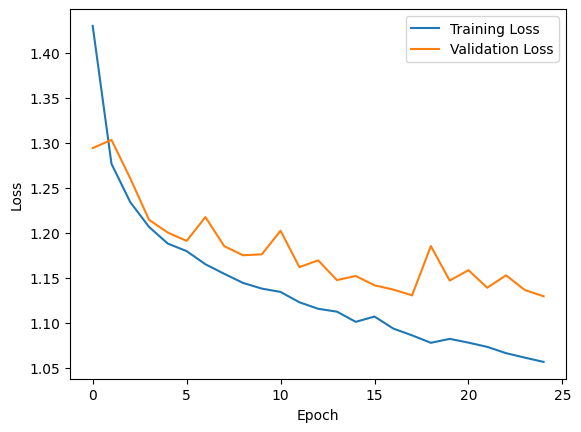

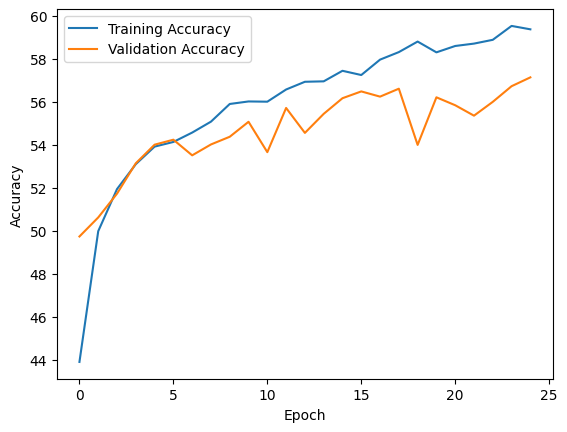

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [17]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_22480\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:21<00:00,  3.47it/s]


Test Results (Best Model):
Test Loss: 1.1414
Test Accuracy: 56.66%


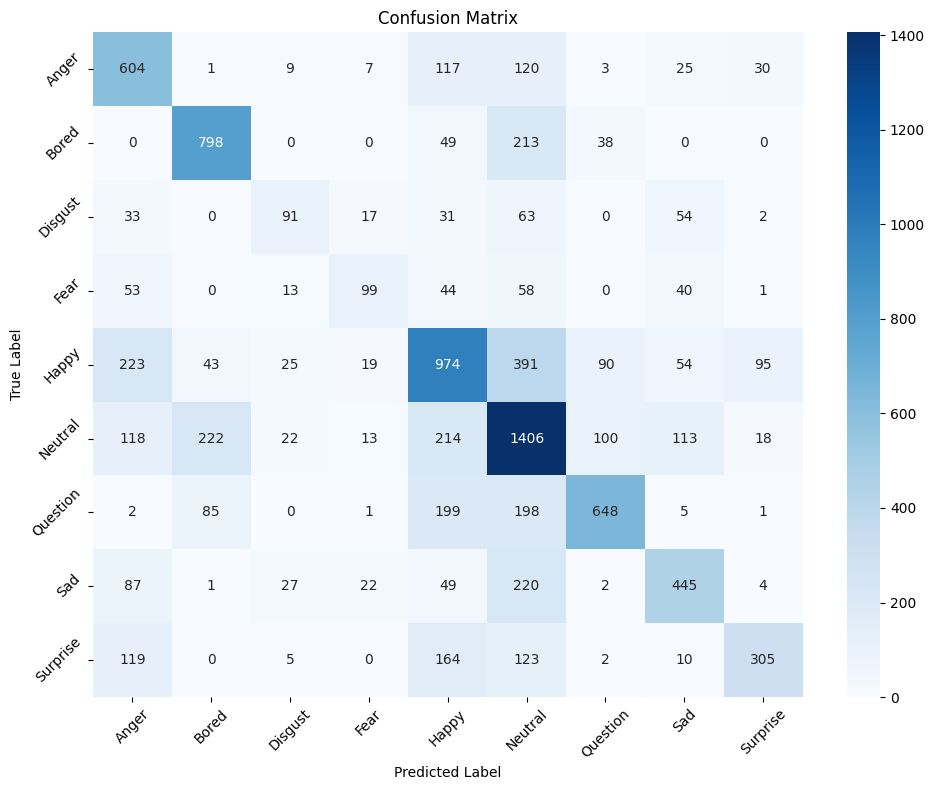

In [18]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)